# Make Models

We want to verify that the method works on synthetic data. We use the MAP model from fitting the circularised data sets which can then be deprojected onto pixel coordinates for a given inclination and position angle. We then include some level of correlated noise into each image.

For a reference, we have a noise level of $22~\mu{\rm Jy\,beam^{-1}}$ noise level for the Band 6 data, peaking at a SNR of 170 and a noise level of $39~\mu{\rm Jy\,beam^{-1}}$ for the Band 7 data, peaking at a SNR of 85.

In [9]:
%matplotlib inline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

In [49]:
# Make interpolatable radial functions.
B6 = np.load('../models/B6c_MAP.npy')
B6[1] = np.max([np.zeros(B6[0].size), B6[1] - B6[1, -1]], axis=0)
B6 = interp1d(B6[0], B6[1] / B6[1].max(),
              bounds_error=False, fill_value='extrapolate')
B7 = np.load('../models/B7c_MAP.npy')
B7[1] = np.max([np.zeros(B7[0].size), B7[1] - B7[1, -1]], axis=0)
B7 = interp1d(B7[0], B7[1] / B7[1].max(),
              bounds_error=False, fill_value='extrapolate')

Text(0,0.5,'Normalised Intensity')

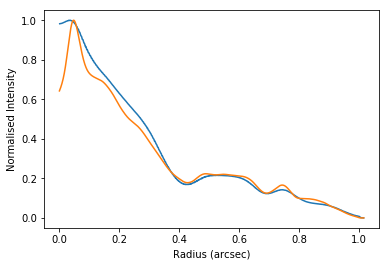

In [53]:
# Plot the profiles to check they're OK.
fig, ax = plt.subplots()
l = ax.plot(B6.x, B6.y, ls='-')
l = ax.plot(B7.x, B7.y, ls='-')
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Normalised Intensity')

In [54]:
# Load up the cubes to steal the headers.
from imgcube.cube import imagecube
B6_cube = imagecube('../data/cont/TWHya.230GHz.circ.fits')
B7_cube = imagecube('../data/cont/TWHya.345GHz.circ.fits')

In [87]:
# Function to make and save models.
from astropy.io import fits
def make_model(cube, profile, inc, PA, x0=0.0, y0=0.0, rms=0.0, filename=None):
    """Make a synthetic model and save if `filename` is provided."""
    
    # Make the synthetic observations.
    data = profile(cube.disk_coords(x0=x0, y0=y0, inc=inc, PA=PA)[0])
    if rms > 0.0:
        data += cube.correlated_noise(rms=rms, bmaj=cube.bmaj)
    if filename is None:
        return data
    
    # Save the file if required.
    if filename[-5:] != '.fits':
        filename += '.fits'
    hdu = fits.open(cube.path)
    hdu[0].data = data
    hdu.writeto(filename, overwrite=True, output_verify='fix')

(-1.2, 1.2)

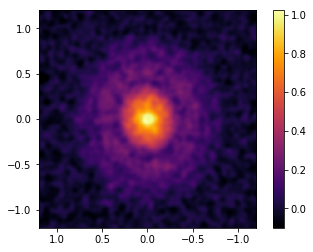

In [105]:
# Check to make sure.
fig, ax = plt.subplots()
im = ax.imshow(make_model(B6_cube, B6, inc=30.0, PA=170.0, rms=0.03),
               extent=B6_cube.extent, cmap='inferno', vmin=-0.1)
plt.colorbar(im)
ax.set_xlim(1.2, -1.2)
ax.set_ylim(-1.2, 1.2)

In [98]:
# Different signal to noise ratios.
for inc in [4.0, 5.5, 7.0]:
    for rms in [1e-2, 3e-3, 1e-3, 3e-4]:
        make_model(B6_cube, B6, inc=inc, PA=151.0, rms=rms,
                   filename='../models/B6_inc%.1f_rms%.1e.fits' % (inc, rms))
        make_model(B7_cube, B7, inc=inc, PA=151.0, rms=rms,
                   filename='../models/B7_inc%.1f_rms%.1e.fits' % (inc, rms))